# Filtrado de imágenes usando transformada de Fourier
<section class="post-meta">
Carlos Ruestes, Cristián Sanchez
</section>
Última edición: 30 de Septiembre de 2019
___

## Introducción

En este notebook discutiremos la transformada de Fourier bidimensional y su uso en filtrado de imágenes. Si desean un conocimiento conceptual más profundo, pueden ver las referencias al final de este notebook. Recuerden que podemos interpretar la transformada de Fourier del dominio espacial (aquí son las imágenes) como el dominio de frecuencias, o el espectro de frecuencias. Por simplicidad, usaremos imágenes en escala de grises, pero es relativamente sencillo generalizar esto a imágenes a color.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as fft
from skimage import io
import warnings
%matplotlib inline

# Tomar el logaritmo de cero al visualizar el espectro da advertencias,
# así que las desactivamos
warnings.filterwarnings("ignore")

## Transformada de fourier de una imagen

Para simplificar y minimizar la implementación de código, creamos una función para visualizar una imagen y su correspondiente espectro en el dominio de frecuencias. Nótese que graficamos el logaritmo del valor absoluto. 

In [2]:
def visualise(image, spectrum, title='', title_img='', title_spec='', cmap='gray'):
    """ Visualizar una image y su espectro en frec. en una figura.
    
    Parametros:
        image: en forma de array, como en plt.imshow(). Imagen.
        spectrum:en forma de array, como en plt.imshow(). Espectro.
        title: string. Titulo. Opcional.
        title_img. string. Subtitulo. Opcional.
        title_spec. string. Subtitulo Espectro. Opcional.
        cmap: `~matplotlib.colors.Colormap`. Color map. Opcional.
    """
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    plt.imshow(image, cmap=cmap)
    plt.title(title_img)
    plt.subplot(122)
    plt.imshow(np.log(abs(spectrum)), cmap=cmap)
    plt.title(title_spec)
    plt.suptitle(title)
    plt.show()

Creamos dos funciones para calcular la transformada de Fourier y la antitransformada de una imagen. Nótese que estas funciones también desplazan los cuadrantes, de manera que las frecuencias bajas aparecen hacia el medio del espectro y la frecuencia aumenta a medida que lo hace la distancia al centro. Es una convención que se encuentra frecuentemente en la literatura. 

In [3]:
def FFT(image):
    """ Computa la FFT discreta 2D de una imagen y desplaza el cero de frec.
    hacia el centro del espectro.
    
    Parametros:
        image: en forma de array, dimension (m,n), puede ser complejo.
    Returns: ndarray complejo, dimension (m,n). Espectro.
    """
    return np.fft.fftshift(np.fft.fft2(image))

def IFFT(spectrum):
    """ Desplaza el cero de frec. hacia los extremos del espectro y 
    computa la anti FFT discreta 2D de una imagen.
    
    Parametros:
        spectrum: forma de array, dimension (m,n), puede ser complejo.
    Returns: ndarray complejo, dimension (m,n). Dominio espacila.
    """
    return np.fft.ifft2(np.fft.fftshift(spectrum))

Tomemos la transformada rápida de una imagen y grafiquemos el resultado.

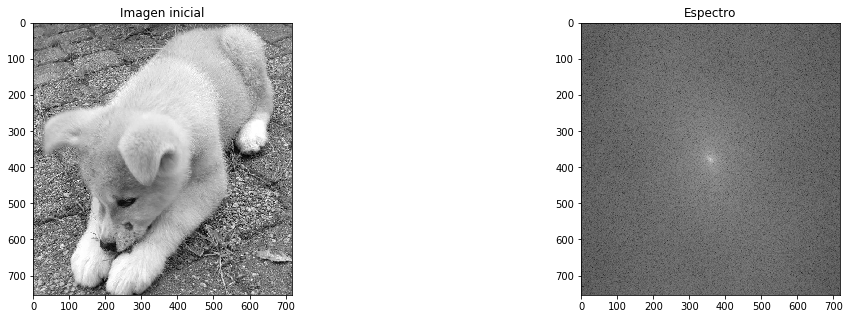

In [5]:
img = io.imread('imagesFFT/dog.jpg', as_grey=True)

spec = FFT(img)
visualise(img, spec, title_img='Imagen inicial', title_spec='Espectro')

## Filtrado

Hay una cantidad innumerable de filtros que se pueden utilizar sobre el dominio en frecuencia para filtrar la imagen original. Vamos a implementar filtros de bajas y altas frecuencias en forma de filtro pasa-altos y pasa-bajos, respectivamente. Usaremos un filtro ideal y un filtro gaussiano en ambos casos.

Se asume que la imagen en cuestión tiene $n$ pixeles horizontales (dirección $x$) y $m$ pixeles verticales (dirección $y$). Sea $x=0,1,...,n-1$ e $y=0,1,..,m-1$ que definen una grilla cuadrada $x \times y$. Denotemos al espectro en frecuencia como $\mathcal F$, los filtros ideales como $I_\text{lowpass}$ e $I_\text{highpass}$ y los filtros gaussianos como $G_\text{lowpass}$ y $G_\text{highpass}$, todos definidos en la grilla $x \times y$. Definimos estos filtros tal que un espectro filtrado esta dado por el producto matricial elemental  $\mathcal F\circ I$ y $\mathcal F\circ G$.

$r=\sqrt{(x-n/2)^2+(y-m/2)^2}\geq0$ es la distancia desde el centro del espectro. Los filtros que consideramos dependen solo de un parámetro $\xi\in \mathbb{R}^+$. En esta notación, los filtros ideales estan dados por

$$
I_\text{lowpass}=\begin{cases}
1,& \text{si } r\leq\xi,\\
0,& \text{si } r>\xi,
\end{cases}
\quad \text{y} \quad
I_\text{highpass}=\begin{cases}
1,& \text{si } r\geq\xi,\\
0,& \text{si } r<\xi,
\end{cases}
$$

mientras que los filtros gaussianos estan dados por

$$
G_\text{lowpass}=e^{-\xi r^2}
\quad \text{y} \quad
G_\text{highpass}=1-e^{-\xi r^2}.
$$

In [6]:
def filter_spectrum(spectrum, filter_type=None, val=50):
    """ Filtrado del espectro de una imagen de acuerdo a definicion.
    
    Parametros:
        spectrum:   array, dimension (m, n), puede ser complejo. Espectro a filtrar.
        filter_type: string. Nombre del filtro, 
                     {'lowpass', 'highpass', 'gaussian_highpass', 'gaussian_lowpass'}.
        val:         float. Parametro del filtro.
    Returns: ndarray complejo, dimension (m, n). Espectro filtrado.
    """
    n, m = np.shape(spectrum)
    y, x = np.meshgrid(np.arange(1, m + 1), np.arange(1, n + 1))
    R2 = ((x - n/2)**2 + (y - m/2)**2)
    if (filter_type == 'lowpass'):
        return spectrum*(R2 <= val**2)
    elif (filter_type == 'highpass'):
        return spectrum*(R2 >= val**2)
    elif (filter_type == 'gaussian_highpass'):
        return spectrum*(1 - np.exp(-val*R2))
    elif (filter_type == 'gaussian_lowpass'):
        return spectrum*np.exp(-val*R2)
    elif (filter_type != None):
        raise ValueError('%s is not a valid filter!' % (filter_type))
    return spectrum

Ahora usamos estos filtros en el espectro de frecuencia y antitransformamos para obtener imágenes filtradas. Nótese que las imagenes filtradas con el filtro gaussiano se presentan como más suaves que aquellas con filtro ideal.

### Pasa-bajos

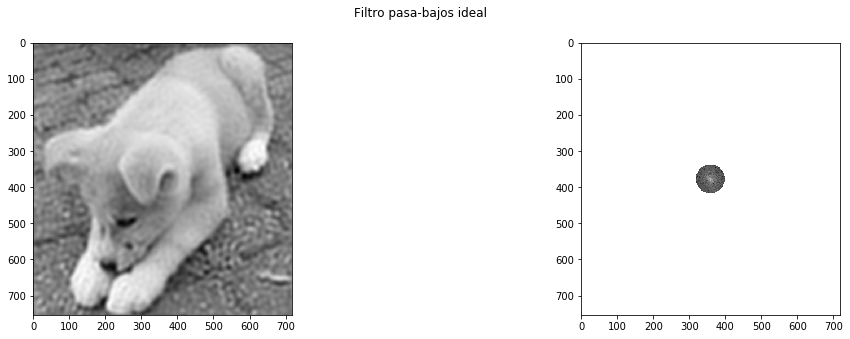

In [11]:
filtered_spec = filter_spectrum(spec, 'lowpass', 40)  #Prueben modificar el valor de 40.
filtered_img = np.real(IFFT(filtered_spec))
visualise(filtered_img, filtered_spec, title='Filtro pasa-bajos ideal')

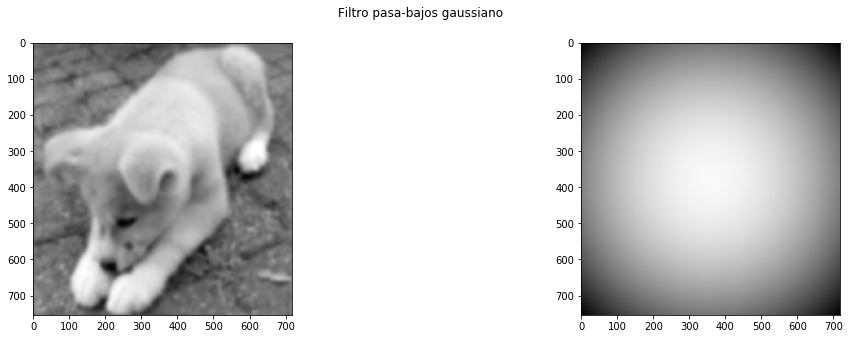

In [13]:
filtered_spec = filter_spectrum(spec, 'gaussian_lowpass', 0.001)
filtered_img = np.real(IFFT(filtered_spec))
visualise(filtered_img, filtered_spec, title='Filtro pasa-bajos gaussiano')

### Pasa-altos

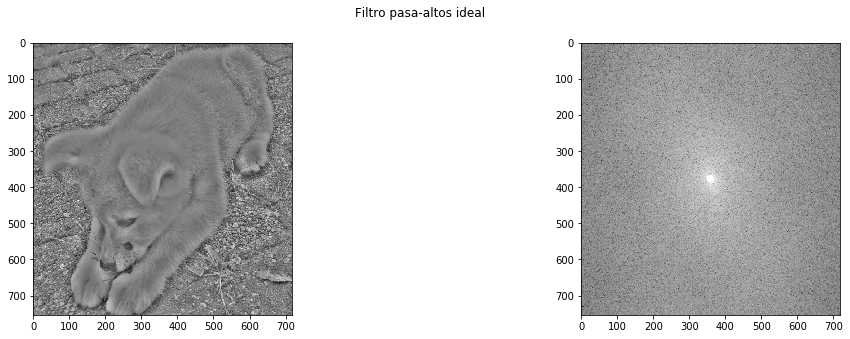

In [14]:
filtered_spec = filter_spectrum(spec, 'highpass', 10)
filtered_img = np.real(IFFT(filtered_spec))
visualise(filtered_img, filtered_spec, title='Filtro pasa-altos ideal')

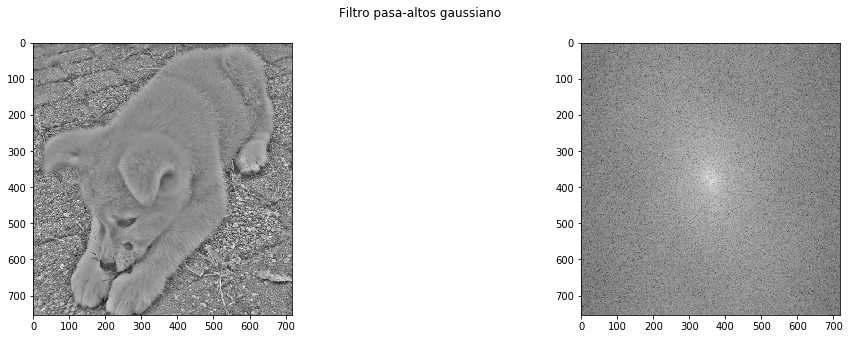

In [15]:
filtered_spec = filter_spectrum(spec, 'gaussian_highpass', 0.01)
filtered_img = np.real(IFFT(filtered_spec))
visualise(filtered_img, filtered_spec, title='Filtro pasa-altos gaussiano')

## Filtrando patrones específicos y ruido

En los próximos ejemplos incluímos una imagen con patrones de ruido. Se las transforma al dominio de frecuencias, se le quitan las anomalías y se obtienen imágenes filtradas antitransformando al dominio espacial.

### Ejemplo 1

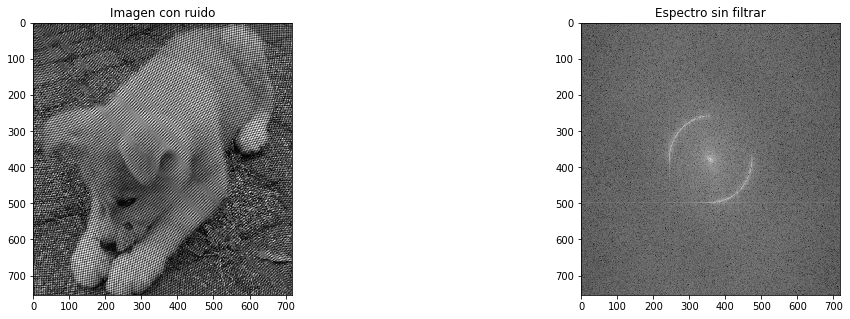

In [16]:
img = io.imread('imagesFFT/dog_noise1.jpg', True)
spec = FFT(img)
visualise(img, spec, title_img='Imagen con ruido', title_spec='Espectro sin filtrar')

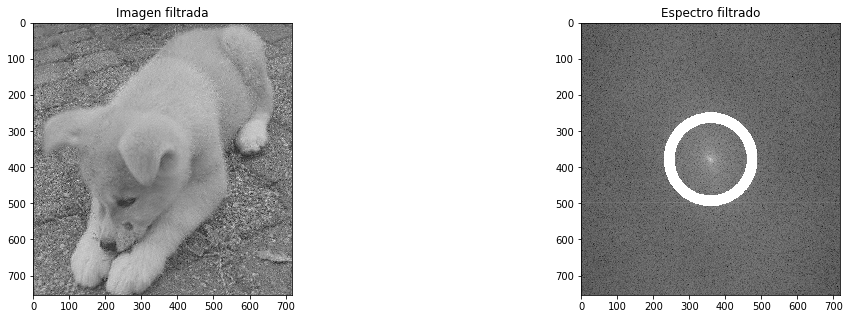

In [20]:
# Crear un filtro para quitar la anomalía (Conversemos como se ve la misma)
n, m = np.shape(img)
y, x = np.meshgrid(np.arange(m), np.arange(n))
R2 = (x - n/2)**2 + (y - m/2)**2
filtered_spec = spec*(R2 <= 100**2) + spec*(R2 >= 130**2) #Prueben otros valores!
filtered_img = np.real(IFFT(filtered_spec))

# Visualizamos el resultado
visualise(filtered_img, filtered_spec, title_img='Imagen filtrada',
          title_spec='Espectro filtrado')

### Ejemplo 2

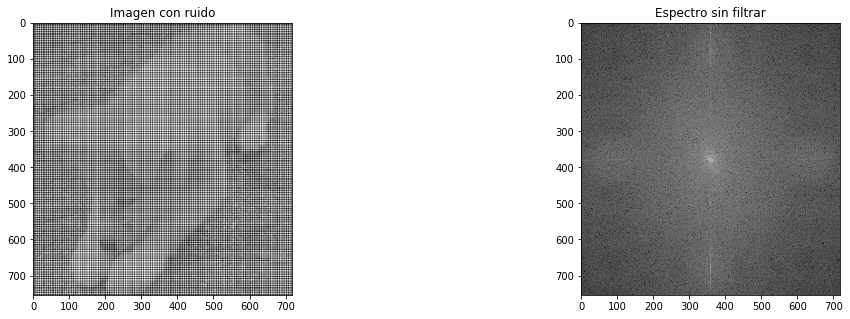

In [21]:
img = io.imread('imagesFFT/dog_noise2.jpg', True)
spec = FFT(img)
visualise(img, spec, title_img='Imagen con ruido', title_spec='Espectro sin filtrar')

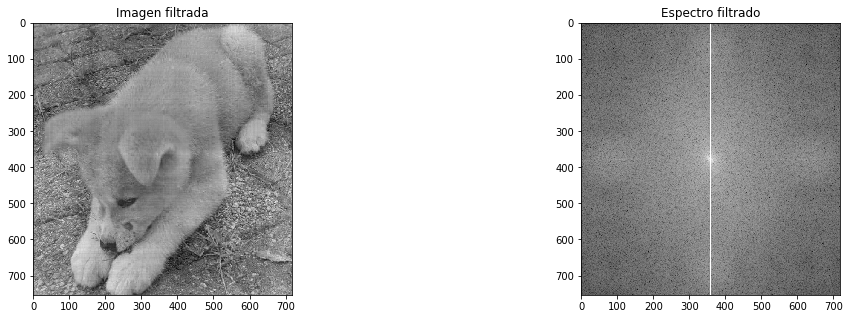

In [22]:
# Crear un filtro para quitar la anomalía (Conversemos como se ve la misma)
n, m = np.shape(img)
y, x = np.meshgrid(np.arange(m), np.arange(n))
filtered_spec = spec*(x <= n/2 - 1) + spec*(x >= n/2 + 1)
filtered_spec = filtered_spec*(y <= m/2 - 1) + filtered_spec*(y >= m/2 + 1)
filtered_img = np.real(IFFT(filtered_spec))

# Visualise result
visualise(filtered_img, filtered_spec, title_img='Imagen filtrada',
          title_spec='Espectro filtrado')

### Lectura extra


* Robert Fisher, Simon Perkins, Ashley Walker and Erik Wolfart: Fourier Transform, http://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm, 2000.
* Paul Bourke: Image Filtering in the Frequency Domain, http://paulbourke.net/miscellaneous/imagefilter/, 1998.
* Steven Lehar: An Intuitive Explanation of Fourier Theory, http://cns-alumni.bu.edu/~slehar/fourier/fourier.html.

Multi-dimensional image processing using scipy: https://docs.scipy.org/doc/scipy-0.18.1/reference/ndimage.html